In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("claims") \
    .getOrCreate()

In [3]:
#%%time
#!cat harvester/claims/*CLAIMS*jsonl > harvester/claims/aggregated.jsonl

In [4]:
%%time
df = spark.read.json("harvester/claims/aggregated.jsonl")

CPU times: user 337 µs, sys: 1.93 ms, total: 2.27 ms
Wall time: 2.01 s


In [5]:
!wc -l harvester/claims/aggregated.jsonl

3044 harvester/claims/aggregated.jsonl


In [6]:
!cat harvester/claims/aggregated.jsonl | grep '2023-12-08'

grep: (standard input): binary file matches


In [7]:
df.count()

3044

In [8]:
df = df.where("version = '0.0.2'")
df.sort(F.col("scraped_at").desc()).show()

+---------------+------+-------------+--------------------+--------------------+--------------------+-------+
|_corrupt_record| claim|      crawler|          scraped_at|                 url|                uuid|version|
+---------------+------+-------------+--------------------+--------------------+--------------------+-------+
|           null|133089|ClaimsCrawler|2023-12-10 13:48:...|https://www.occ.c...|b5cd84de-641d-4b0...|  0.0.2|
|           null|  2074|ClaimsCrawler|2023-12-10 13:48:...|https://www.emple...|e13cdd62-b456-42b...|  0.0.2|
|           null|  1579|ClaimsCrawler|2023-12-10 13:48:...|https://hireline....|6fe75fa5-fb35-4d0...|  0.0.2|
|           null| 92961|ClaimsCrawler|2023-12-10 13:48:...|https://co.comput...|d9502aaa-0455-489...|  0.0.2|
|           null|127140|ClaimsCrawler|2023-12-10 13:48:...|https://mx.comput...|c024ea5e-d868-439...|  0.0.2|
|           null|104646|ClaimsCrawler|2023-12-10 13:48:...|https://www.emple...|db4bf7b6-d0cc-4de...|  0.0.2|
|         

In [9]:
df.select("url").distinct().collect()

[Row(url='https://co.computrabajo.com'),
 Row(url='https://www.occ.com.mx/empleos/de--/'),
 Row(url='https://mx.computrabajo.com'),
 Row(url='https://hireline.io/mx/empleos'),
 Row(url='https://www.empleo.gob.mx/api/Login/homeSinSesion'),
 Row(url='https://www.empleonuevo.com/empleos')]

<Figure size 1800x600 with 0 Axes>

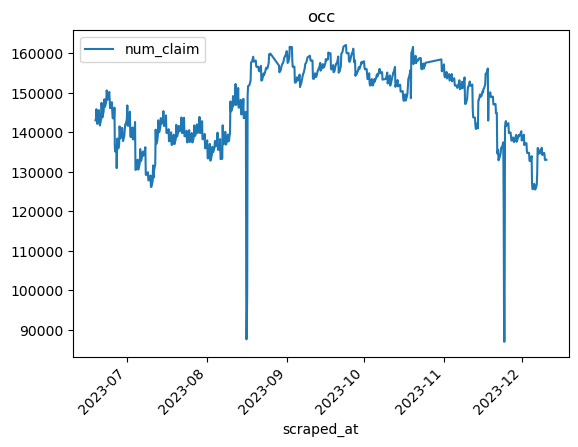

In [10]:
plt.figure(figsize=(18,6))
data = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data['scraped_at'] = pd.to_datetime(data['scraped_at'])
data.plot("scraped_at", "num_claim")
plt.title("occ")
_ = plt.xticks(rotation=45)

In [11]:
data

,_corrupt_record,claim,crawler,scraped_at,url,uuid,version,num_claim
0,None,143063,ClaimsCrawler,2023-06-18 16:00:44.927250,https://www.occ.com.mx/empleos/de--/,082e38b5-6379-46b3-ac33-de0a647ffadf,0.0.2,143063
1,None,143082,ClaimsCrawler,2023-06-18 20:00:44.329050,https://www.occ.com.mx/empleos/de--/,2a30674c-ca13-4da2-a3f9-bfb2adef5545,0.0.2,143082
2,None,145898,ClaimsCrawler,2023-06-19 00:00:48.557039,https://www.occ.com.mx/empleos/de--/,5b908799-73e2-4106-9b86-f9b97decd67e,0.0.2,145898
3,None,144438,ClaimsCrawler,2023-06-19 04:00:45.723339,https://www.occ.com.mx/empleos/de--/,7eb416ae-0c05-4a83-8e77-82f65c16657e,0.0.2,144438
4,None,142183,ClaimsCrawler,2023-06-19 08:00:45.075144,https://www.occ.com.mx/empleos/de--/,4646343c-2338-48b3-bf1b-15588d2586ed,0.0.2,142183
...,...,...,...,...,...,...,...,...
978,None,133039,ClaimsCrawler,2023-12-10 00:00:49.673164,https://www.occ.com.mx/empleos/de--/,d2a9b00e-1391-422b-90b9-cf4805624650,0.0.2,133039
979,None,133068,ClaimsCrawler,2023-12-10 06:00:50.211619,https://www.occ.com.mx/empleos/de--/,5cf63fa9-ccfa-49d9-8f37-36aaffa025bb,0.0.2,133068
980,None,133087,ClaimsCrawler,2023-12-10 12:00:52.184540,https://www.occ.com.mx/empleos/de--/,14a06274-938d-446d-bf06-6502528165be,0.0.2,133087
981,None,133087,ClaimsCrawler,2023-12-10 12:33:55.709659,https://www.occ.com.mx/empleos/de--/,a93015df-d5d5-41bc-a4b2-be8f3b9caa97,0.0.2,133087


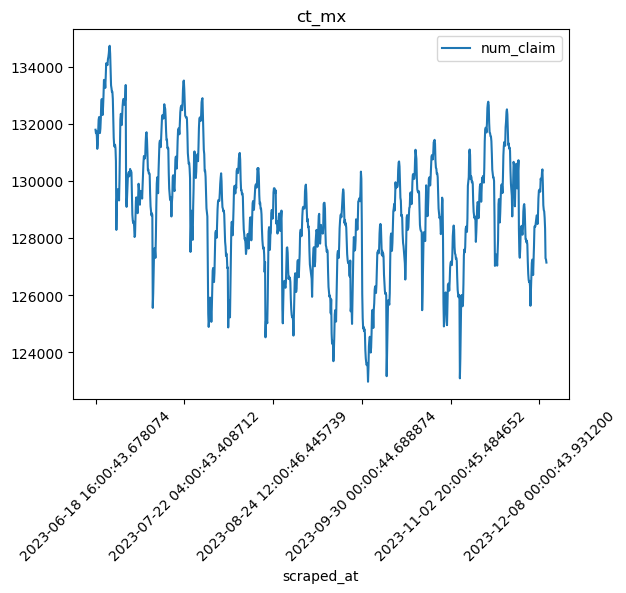

In [12]:
data = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_mx")
_ = plt.xticks(rotation=45)

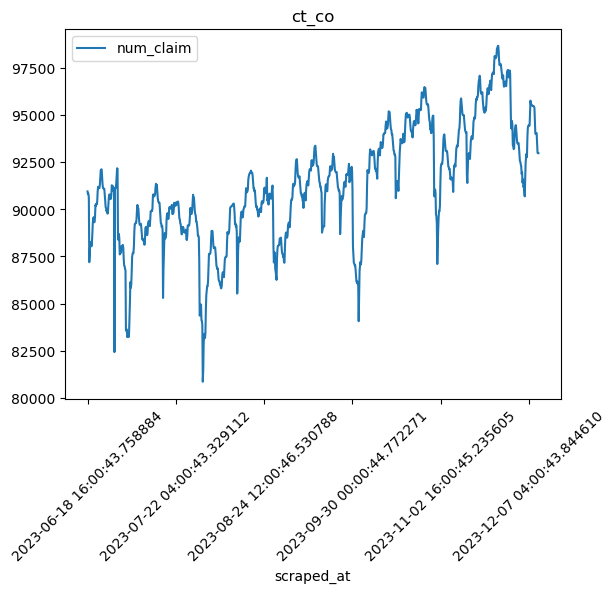

In [13]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

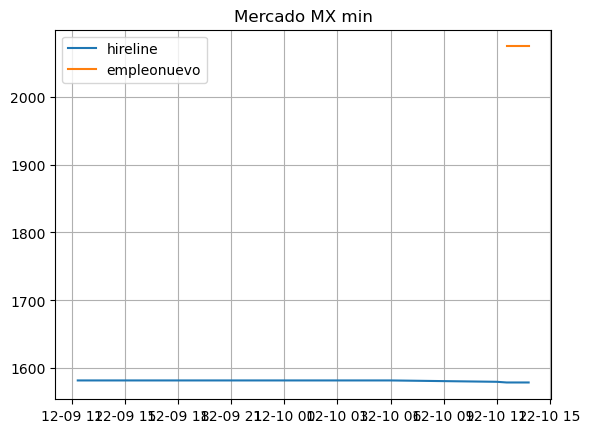

In [17]:
hl = df.where(df.url.startswith("https://hireline.io/mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
en = df.where(df.url.startswith("https://www.empleonuevo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl['scraped_at'] = pd.to_datetime(hl['scraped_at'])
en['scraped_at'] = pd.to_datetime(en['scraped_at'])
plt.grid(which="both")
plt.title("Mercado MX min")
_=plt.plot(hl.set_index('scraped_at'))
_=plt.plot(en.set_index('scraped_at'))
plt.legend(['hireline', 'empleonuevo'])


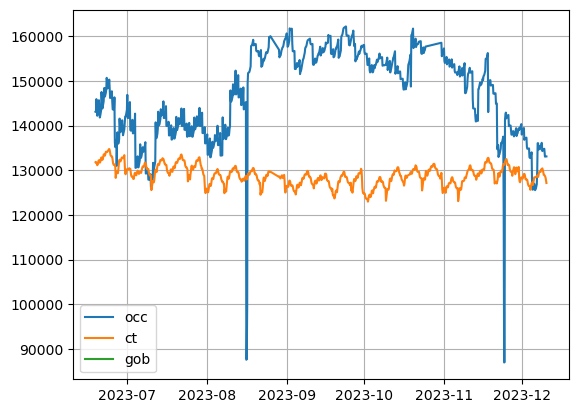

In [19]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
gob = df.where(df.url.startswith("https://www.empleo.gob.mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct['scraped_at'] = pd.to_datetime(ct['scraped_at'])
occ['scraped_at'] = pd.to_datetime(occ['scraped_at'])
gob['scraped_at'] = pd.to_datetime(gob['scraped_at'])

plt.plot(occ.set_index('scraped_at'))
plt.plot(ct.set_index('scraped_at'))
plt.plot(gob.set_index('scraped_at'))
plt.grid(which="both")
plt.legend(['occ', 'ct', 'gob'])
plt.show()

In [20]:
gob

,scraped_at,num_claim
0,2023-12-10 13:48:40.934531,104646


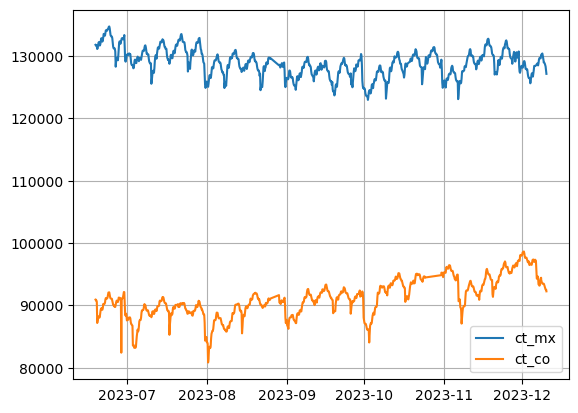

In [16]:
ct_mx = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
ct_co = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct_mx['scraped_at'] = pd.to_datetime(ct['scraped_at'])
ct_co['scraped_at'] = pd.to_datetime(occ['scraped_at'])

plt.plot(ct_mx.set_index('scraped_at'))
plt.plot(ct_co.set_index('scraped_at'))
plt.grid(which="both")
plt.legend(["ct_mx", "ct_co"])
plt.show()